# Project Forensics

---

## Setup


### Working Directory

This just helps with using local imports from the larger project to the notebook.

In [1]:
cd ../

/Users/chrismessier/work/behaviorally


### Imports

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
import os

from google.protobuf.struct_pb2 import Struct
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_pb2, status_code_pb2

#### Plotting Config

In [4]:
%matplotlib inline
sns.set(
    style='darkgrid'
)

### Methods

In [5]:
def load_spreadsheet(f):
    pass

### Client Initialization

In [6]:
channel = ClarifaiChannel.get_json_channel()
stub = service_pb2_grpc.V2Stub(channel)

In [7]:
API_KEY = None

In [8]:
metadata = (('authorization', f'Key {API_KEY}'),)  # key value referenced from config module

## Analysis

### Background

### Spreadsheets

There were three spreadsheets shared with me, which I have uploaded to the following Google Sheets:

- [[BEHAVIORALLY] ONS Validation_dcs_processed_v1.3.xlsx](https://docs.google.com/spreadsheets/d/12aDefcKhb9-LSILRo0t5ttLLxvxfe81ft-MYJhLbVYk/edit?usp=sharing)
- [[BEHAVIORALLY] IRI Data Product List_3.21.22.xlsx](https://docs.google.com/spreadsheets/d/1HCsjUscUtgbhRXdIfxcJCENzz2ZhwicnJcwcEoZuoYw/edit#gid=1323785198)
- [[BEHAVIORALLY] Behaviorally - Report 4.18.22[8].xlsx](https://docs.google.com/spreadsheets/d/169Bu7yhN6tuTpAgQAr2BV-l8MBxCwEpvAVkR2PDjZBA/edit?usp=sharing)

As well as one `.eml` file:

- 'data/Re- Respondent database request.eml'

Upon quick inspection, the `.eml` file appears to be email records.
I saw the name "Durga" which was also the name of one of the correspondents on the email chain Bryan forwarded to me as well.
I've been told to ignore this file for the time being.

In [9]:
doc_1 = '/Users/chrismessier/work/behaviorally/data/Behaviorally - Report 4.18.22[8].xlsx'
doc_2 = '/Users/chrismessier/work/behaviorally/data/IRI Data Product List_3.21.22.xlsx'
doc_3 = '/Users/chrismessier/work/behaviorally/data/ONS Validation_dcs_processed_v1.3.xlsx'

In [10]:
d = pd.read_excel(doc_3, sheet_name=None)  # coerce it to parse all sheets and return a dict

After checking on this the 'Report' spreadsheet, isn't super well organized by sheets, as it's just incremental integers.
I will need to dig into the structure a bit...

After looking into the sheets, each of these is a report.
In each sheet there's more information on the associated report.
What's more important though, is the information I got from Bryan about the project.

There are two files of interest, [`doc_1`](https://docs.google.com/spreadsheets/d/12aDefcKhb9-LSILRo0t5ttLLxvxfe81ft-MYJhLbVYk/edit?usp=sharing)

Suddenly, a wild spreadsheet appeared!

> [ONS_output_Tony_Round 1.xlsx](https://docs.google.com/spreadsheets/d/1ft-XNY-UQbcVsivONW7Ig9byVTxBkRHJ/edit?usp=sharing&ouid=116368867705255658120&rtpof=true&sd=true)

Which was downloaded locally, and can be set...

In [11]:
doc_4 = '/Users/chrismessier/work/behaviorally/data/ONS_output_Tony_Round 1.xlsx'

These are the results that @tony(?) got when running the model(s) for Behaviorally.
What is of interest is a correlation between these scores, and the revenue(?) that can be found somewhere in [these](https://docs.google.com/spreadsheets/d/169Bu7yhN6tuTpAgQAr2BV-l8MBxCwEpvAVkR2PDjZBA/edit?usp=sharing) reports.
I'm going to start with getting the scores in first...

The scores are contained in [this spreadsheet](https://docs.google.com/spreadsheets/d/1qJ4lYdJzrzfmzTB2v7BVMAzO3XZZXcpX/edit?usp=sharing&ouid=116368867705255658120&rtpof=true&sd=true).

According to @bryan there is only one sheet of interest, `'ONS_output_Tony'`, so we will simply parse it accordingly: no need for a fancy-pants parser. 😒


### `ONS_output_Tony_Round 1.xlsx:ONS_output_Tony` 

In [12]:
# @mess: @bryan, seeing as this may be the first time you are reviewing my work in this, I want to work flow explicit.  
# I'm going to be using non-descript 'df' locally for testing, once a snippet/script is complete, that will be abstracted into a function/method/object at the top of the notebook.
# The purpose of this is to provide easy 'breadcrumbs' for future iterations, which should always involve moving these completed snippets to stand-alone modules.
# It is at this point that documentation standards _should_ be enforced, but we're nowhere near that point...

target_sheet = 'ONS_output_Tony'

df = pd.read_excel(doc_4, sheet_name=target_sheet)


In [13]:
df.head()

,Image Name,Image ID,Raw ONS Line and Pack
0,AB005_LINE1A.jpg,LINE1A,45.0
1,AB005_LINE1B.jpg,LINE1B,67.0
2,AB005_LINE2A.jpg,LINE2A,77.0
3,AB005_LINE2B.jpg,LINE2B,51.0
4,AB005_LINE3A.jpg,LINE3A,47.0


In [14]:
df.shape

(4758, 3)

In [15]:
df.describe(include='all')

,Image Name,Image ID,Raw ONS Line and Pack
count,4758,4758,4758.000000
unique,4758,324,NaN
top,AB005_LINE1A.jpg,LINE1,NaN
freq,1,363,NaN
mean,NaN,NaN,49.146490
std,NaN,NaN,24.925337
min,NaN,NaN,1.000000
25%,NaN,NaN,27.000000
50%,NaN,NaN,50.000000
75%,NaN,NaN,72.000000


The columns are fairly self explanatory; but it is worth being explicit.

- `Image Name`: the image file provided as an input for inference.
- `Image ID`: the type of image, where
    - 'LINE' is series of different items are arranged in a line, and
    - 'PACK' is a single item, but the image may contain multiple instances of that item. 
- `Raw ONS Line and Pack`: the 'output' score from - control yourself, @mess, some boxes need to remain opaque! - whatever process there is.

From my conversation w/ @bryan there's a little more information that can be surfaced.
The `Image Name` values are actually a concatenation of the implied "_Item ID_" and the existing (hopefully...) `Image ID`.

#### An aside on convention

>A quick note here, but I've tried to adhear to these naming conventions when it comes to client spreadsheets and the manipulation thereof.
>For original column names, I try to keep them as-is from the customer.
>For any generated columns, I always adhear to the local variable naming convention; and Clarifai is the wild west, I defer to PEP8 and use snake case.
>An example of which can be seen below.

In [16]:
# NOTE 'item_id' should be changed to 'JobNumber' to conform to the client's usage
df['item_id'] = df['Image Name'].apply(lambda s: s.split('_')[0].strip())  # retrieving the first item of the concatenated Image Name

In [17]:
df.head()

,Image Name,Image ID,Raw ONS Line and Pack,item_id
0,AB005_LINE1A.jpg,LINE1A,45.0,AB005
1,AB005_LINE1B.jpg,LINE1B,67.0,AB005
2,AB005_LINE2A.jpg,LINE2A,77.0,AB005
3,AB005_LINE2B.jpg,LINE2B,51.0,AB005
4,AB005_LINE3A.jpg,LINE3A,47.0,AB005


In [18]:
'AD905' in df['item_id'].values.tolist()

True

In [19]:
# phi = 1.0
# N = df['item_id'].nunique()

# fig, ax = plt.subplots(1, 1, figsize = (10, N*phi)) # WARNING BIIIIIG plot
# sns.countplot(data=df, y='item_id');  

In [20]:
# sns.countplot(data=df, x='item_id');  # this isn't that helpful, given the high cardinality. see below.
df['item_id'].nunique()

536

What is the distribution of the ONS scores?

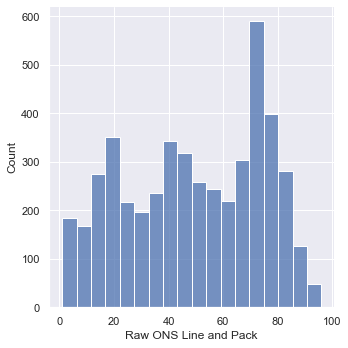

In [21]:
sns.displot(data=df, x='Raw ONS Line and Pack')

It looks like a multi-modal distribution, censored outside the interval $[0, 100]$.

In [22]:
results = df.copy()

### `Behaviorally - Report 4.18.22[8].xlsx`

This spreadsheet contains a set of reports, on each sheet therein there is an individual "report".
The reports correspond to some time interval, and are indexed with incremented integers.
On each sheet, there is also what looks like a screen shot of some information.
I will include a screenshot of this below:

![Behaviorally report spreadsheet, upper left-hand corner](./assets/image1.jpeg)

This actually seems to be the only source of time information, so we'll need to go back through and update this manually; mapping the integer-indices to the report dates.
For now I'll just work with the integer information.

The problem with that screenshot-labeling scheme that Behaviorally is using is that it creates the offset with the rows which needs to be accounted for.
First, I'm going to check to see if the offset is consistent.

This is important to note: there's actually a starting sheet that has information on the reports across the different sheets; but I'm going to ignore it for now.

After "sampling" 12 different sheets (I flicked my mouse across the slider on Google sheets and _tried_ to select randomly), I can confidently say that aside from the `'Index'` sheet, the offset for the headers is constant: 8 rows (see screenshot above, as well).

In [23]:
def process_behaviorally_reports(doc, row_offset=7):
    d = pd.read_excel(doc, sheet_name=None)
    assert 'Index' in d.keys(), f"This doesn't look like the right type of spreadsheet: {doc}"
    _ = d.pop('Index')  # hack way to get rid of the index table

    for k, df in d.items():
        # _ = df.dropna(axis=0, inplace=True)  # this will still leave the conversion artifacts like "Unamed: 0"
        df.columns = df.iloc[row_offset-1].values
        _df = df.iloc[row_offset:,].copy()  # using -1 to try and preserve the headers
        d[k] = _df

    return d


In [24]:
d = process_behaviorally_reports(doc_1)

for k in d.keys():
    break

d[k].sample()


,Product,Dollar Sales,Dollar Sales % Change vs YA,Unit Sales,Unit Sales % Change vs YA,Unit Share of Category,Unit Share of Category Year Ago,Unit Share of SubCategory,Unit Share of SubCategory Year Ago,Price per Unit,Price per Unit % Change vs YA,UPC 10 digit,Category Name,Sub-Category Name,Brand Name
24,COLGATE RENEWAL COOL MINT ANTICAVITY ANTIGINGI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500098502,TOOTHPASTE,TOOTHPASTE,COLGATE RENEWAL


There's a problem here: there's no direct mapping from the sales figures to the images.
Likely the shortest path is from the `'UPC 10 digit'` (easy-to-use unique value) to the `JobNumber` column in the IRI spreadsheet.

In [25]:
iri = pd.read_excel(doc_2, sheet_name='Full List', )

The UPC values are being read in as integers, and the leading zeroes are being trimmed, as the values are being converted to integers.

After checking the docs, passing in `dtype='object'` should bypass the conversion.

In [26]:
iri = pd.read_excel(doc_2, sheet_name='Full List', dtype='object')

In [27]:
iri[iri['SKU #'] != None]

,JobNumber,Category,Product description,Variant,SKU #,UPC
0,AB238.00,ALCOHOLIC BEV - Beer,Cass Fresh Individual Beer,355mL can and 500mL bottle,NaN,1002334
1,AC156.00,ALCOHOLIC BEV - Beer,"Lagunitas IPA Beer , 6pk/ 12 fl oz bottles","IPA, Hazy Wonder IPA, DayTime IPA",NaN,723830000094
2,AC195.00,ALCOHOLIC BEV - Beer,"Modelo Cantarito Style Cerveza, 12 Fl. Oz Cans...",Hint of Grapefruit Orange & Lime,NaN,33544001011
3,AD055.00,ALCOHOLIC BEV - Beer,Labatt Blue Light Mixer Pack,"Lime, Grapefruit and Blood Orange",NaN,\n271463122-2
4,AD190.00,ALCOHOLIC BEV - Beer,"Blue Moon Light Sky 12 pack, 12 fl oz cans",Tropical Wheat,NaN,71990095925
...,...,...,...,...,...,...
222,AD272.00,PET PRODUCTS - Dog & Cat Supplies & Accessories,Clump & Seal AbsorbX quick absorbing clumping ...,NaN,288682443,33200002079
223,NaN,NaN,NaN,NaN,NaN,NaN
224,AB100.00,PET PRODUCTS - Dog & Cat Treats,Blue Health Bars Original for dogs of all size...,"Baked with bacon, egg & cheese, baked with app...",43710163,840243106332
225,AD214.00,PET PRODUCTS - Dog & Cat Treats,Delectables Lickable Treat Stew for cats 1.4 oz,"Stew with Chicken & Tuna, Bisque with tun and ...",305537145,728925404832


It wasn't _my_ conversion error, it was _THEIR_ conversion error!
Checking the original spread sheet, the original values were trimmed from the start.

I'm going to assume the only zeros that were trimmed were leading zeroes, and given that the corresponding field is `'UPC 10 digit'`, I think padding it should be fairly easy.


In [28]:
iri = iri[~pd.isna(iri['JobNumber'])]  # if it doesn't have a JobNumber, it's of no use here!

In [29]:
iri['trimmed_job_number'] = iri['JobNumber'].apply(lambda x: x.split('.')[0])

In [30]:
iri.head()

,JobNumber,Category,Product description,Variant,SKU #,UPC,trimmed_job_number
0,AB238.00,ALCOHOLIC BEV - Beer,Cass Fresh Individual Beer,355mL can and 500mL bottle,NaN,1002334,AB238
1,AC156.00,ALCOHOLIC BEV - Beer,"Lagunitas IPA Beer , 6pk/ 12 fl oz bottles","IPA, Hazy Wonder IPA, DayTime IPA",NaN,723830000094,AC156
2,AC195.00,ALCOHOLIC BEV - Beer,"Modelo Cantarito Style Cerveza, 12 Fl. Oz Cans...",Hint of Grapefruit Orange & Lime,NaN,33544001011,AC195
3,AD055.00,ALCOHOLIC BEV - Beer,Labatt Blue Light Mixer Pack,"Lime, Grapefruit and Blood Orange",NaN,\n271463122-2,AD055
4,AD190.00,ALCOHOLIC BEV - Beer,"Blue Moon Light Sky 12 pack, 12 fl oz cans",Tropical Wheat,NaN,71990095925,AD190


In [31]:
for i, row in iri.iterrows():
    upc = str(row['UPC'])

    l = len(upc)

    if l > 10:
        print(upc)
        break


723830000094


#### Coming Back

Jumping back into this, I want to sketch the plan for the data manipulation:

- Really, what's needed is the getting a mapping from the UPC codes in the Behaviorally report back to the item codes - JobNumber - from the IRI document.

The main loop will require iterating through the reports though; which we luckily have from `process_behaviorally_reports`.

In [32]:
reports = process_behaviorally_reports(doc_1)

In [33]:
df = reports['1']

In [34]:
for i, row in df.iterrows():  # each row will correspond to an item. need to look up UPC 10 digit
    upc = row['UPC 10 digit']
    matches = iri[iri['UPC'] == upc]['trimmed_job_number'].values.tolist()
    if matches:
        print(upc, matches)
     

2225266004 ['AD692']
3320009994 ['AB249']


So there are only two perfect matches...

In [35]:
for i, row in df.iterrows():
    print(row)
    break

Product                               PEPSI COLA SODA REGULAR CALORIES PLASTIC BOTTL...
Dollar Sales                                                            10160614.125055
Dollar Sales % Change vs YA                                                   -0.037319
Unit Sales                                                               5622407.385457
Unit Sales % Change vs YA                                                     -0.084535
Unit Share of Category                                                         2.455852
Unit Share of Category Year Ago                                                2.381916
Unit Share of SubCategory                                                      3.303385
Unit Share of SubCategory Year Ago                                             3.198081
Price per Unit                                                                 1.807164
Price per Unit % Change vs YA                                                  0.051575
UPC 10 digit                    

In [36]:
from fuzzywuzzy import process

In [37]:
match, score = process.extractOne(upc, iri['UPC'].values)
print(upc, match, score)

1300874833 613008748333 91


In [38]:
# from collections import defaultdict
# d = defaultdict(list)

d = {}

for i, row in df.iterrows():  # each row will correspond to an item. need to look up UPC 10 digit
    upc = row['UPC 10 digit']
    match, score = process.extractOne(upc, iri['UPC'].values)
    # print(f"'UPC 10 digit': {upc}, Fuzzy Match: {match}, {len(str(match))}-digit Score: {score}")

    # d[match].append(upc)
    d[upc] = match

d = dict(d)    

In [39]:
d

{'1200000129': 12000001291,
 '2000001291': 12000001291,
 '4300004301': 43000043011,
 '1200020635': 12000206351,
 '5210004228': 5210004228,
 '3400000229': 34000002290,
 '0462035964': 70462035964,
 '4400005098': 44000050986,
 '2100065883': 21000658831,
 '4112907712': 4112907712,
 '2225266004': '2225266004',
 '2100030047': 2100030047,
 '7020054430': 7020054430,
 '2220095441': 22200954419,
 '4105801321': 841058013211,
 '1058013211': 841058013211,
 '3600053477': 36000534771,
 '3500098502': '35000985026',
 '5898000420': '885898000420',
 '3500097335': 35000973351,
 '3320009994': '3320009994',
 '1111112425': 11111124257,
 '1200001275': 12000012754,
 '1370082425': 13700824258,
 '1901461090': 19014610907,
 '2073511022': 20735110225,
 '3120003469': 31200034694,
 '3270015585': 32700155858,
 '3600049435': 36000494358,
 '4116706651': 41167066515,
 '4650001792': 46500017926,
 '4850002238': 48500022382,
 '4900000044': 49000000443,
 '8769200660': 87692006602,
 '7199028151': 71990281519,
 '8259272064': 

There actually only seem to be a handful of _complete_ mismatches, but this may actually be okay, seeing as we really only need to worry about those items that were used in @tony's tests.
So instead of looking up the upc of items in the reports, start with the inference, get the UPC from the JobNumber, and then look that UPC up in the reports.

In [40]:
results.head()

,Image Name,Image ID,Raw ONS Line and Pack,item_id
0,AB005_LINE1A.jpg,LINE1A,45.0,AB005
1,AB005_LINE1B.jpg,LINE1B,67.0,AB005
2,AB005_LINE2A.jpg,LINE2A,77.0,AB005
3,AB005_LINE2B.jpg,LINE2B,51.0,AB005
4,AB005_LINE3A.jpg,LINE3A,47.0,AB005


In [41]:
# 'AB005' in results['item_id'].values
'AD905' in results['item_id']

False

In [42]:
# d = {}

results['upc'] = None

for i, row in results.iterrows():
    item_id = row['item_id']
    upc = iri[iri['trimmed_job_number'] == item_id]['UPC'].values.tolist()
    if upc:
        # d[item_id] = bool(upc)
        results.loc[results['item_id']==item_id, 'upc'] = upc[0]
    else:
        results.loc[results['item_id']==item_id, 'upc'] = None



In [43]:
results.head()

,Image Name,Image ID,Raw ONS Line and Pack,item_id,upc
0,AB005_LINE1A.jpg,LINE1A,45.0,AB005,None
1,AB005_LINE1B.jpg,LINE1B,67.0,AB005,None
2,AB005_LINE2A.jpg,LINE2A,77.0,AB005,None
3,AB005_LINE2B.jpg,LINE2B,51.0,AB005,None
4,AB005_LINE3A.jpg,LINE3A,47.0,AB005,None


In [44]:
sum(pd.isna(results['upc'])) / results.shape[0]

0.7831021437578815

In [45]:
orig_results = results.copy()
results = results[~pd.isna(results['upc'])].copy()

In [46]:
# sns.displot(data=trim_results, x='Raw ONS Line and Pack', hue='item_id', kind='kde')

Kind of just a mess given the number of `item_id`'s

### Correlations

Now we get to the ultimate question: What are we correlating?

> ONS vs. ???

Obviously the "independent" variable will be the ONS scores, and I believe the "dependent" variable will be the the "Dollar Sales".
I believe the results will need to be aggregated in order to make any sense, seeing as we have multiple variations on sales 


#### Aggregation

##### Revenue reports

In [47]:
# I'm redoing this because returning a dict isn't a useful as combining aggregating the dataframes 

def process_behaviorally_reports(doc, row_offset=7) -> pd.DataFrame:
    d = pd.read_excel(doc, sheet_name=None)
    assert 'Index' in d.keys(), f"This doesn't look like the right type of spreadsheet: {doc}"
    _ = d.pop('Index')  # hack way to get rid of the index table

    dfs = []

    for k, df in d.items():
        # _ = df.dropna(axis=0, inplace=True)  # this will still leave the conversion artifacts like "Unamed: 0"
        df.columns = df.iloc[row_offset-1].values
        _df = df.iloc[row_offset:,].copy()  # using -1 to try and preserve the headers
        _df['REPORT'] = k
        d[k] = _df

        dfs.append(_df)


    return pd.concat(dfs)


In [48]:
reports = process_behaviorally_reports(doc_1)

In [49]:
# reports_agg = reports.groupby('UPC 10 digit')['Dollar Sales'].mean()
reports_agg = reports.groupby('UPC 10 digit').mean()

/Users/chrismessier/virtualenv/v1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [50]:
reports_agg

,Dollar Sales,Dollar Sales % Change vs YA,Unit Sales,Unit Sales % Change vs YA,Unit Share of Category,Unit Share of Category Year Ago,Unit Share of SubCategory,Unit Share of SubCategory Year Ago,Price per Unit,Price per Unit % Change vs YA,REPORT
UPC 10 digit,,,,,,,,,,,
0067203924,6.690451e+05,0.521990,1.252874e+05,0.574600,0.867354,0.765787,1.034775,0.914500,5.388768,0.023886,inf
0067642606,4.386467e+05,0.197919,5.574383e+04,0.172941,0.231149,0.220524,0.462065,0.445185,7.868298,0.019769,inf
0244800086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
0462035964,5.976424e+00,NaN,3.003228e+00,NaN,0.000003,NaN,0.000007,NaN,1.990000,NaN,inf
1058013211,1.043469e+02,-1.000000,9.619680e+00,-1.000000,0.000890,0.000631,0.000890,0.000631,11.220887,-1.000000,inf
1111112425,8.337185e+05,-0.146670,1.305830e+05,-0.164372,0.409650,0.405705,1.110087,1.091302,6.387924,-0.174483,inf
1200000129,1.051269e+07,0.030026,5.587276e+06,-0.009662,2.371235,2.388348,3.217189,3.212130,1.882004,0.039576,inf
1200001275,6.515966e+05,-0.020119,4.070552e+05,-0.042499,0.701865,0.730972,1.080203,1.087757,1.602959,0.023261,inf
1200020635,4.500371e+05,46293.372606,2.035424e+05,44726.331646,0.178286,0.024864,0.188831,0.026434,2.201924,0.153912,inf


##### ONS Scores

Here I am going to get the mean ONS score by item first, as this is the easiest way to look into this.

In [51]:
results['upc'] = results['upc'].astype(str)

In [52]:
results_agg = results.groupby('item_id').mean()

In [53]:
results_agg

,Raw ONS Line and Pack
item_id,
AB012,21.666667
AB018,7.000000
AB031,43.000000
AB052,9.000000
AB111,44.500000
...,...
L2344,37.500000
L2362,37.000000
L2387,44.250000


In [54]:
results_agg['Dollar Sales'] = None

In [55]:
for c in reports_agg.columns:
    if c == 'REPORT': continue
    results_agg.loc[:, c] = None

In [56]:
results_agg

,Raw ONS Line and Pack,Dollar Sales,Dollar Sales % Change vs YA,Unit Sales,Unit Sales % Change vs YA,Unit Share of Category,Unit Share of Category Year Ago,Unit Share of SubCategory,Unit Share of SubCategory Year Ago,Price per Unit,Price per Unit % Change vs YA
item_id,,,,,,,,,,,
AB012,21.666667,None,None,None,None,None,None,None,None,None,None
AB018,7.000000,None,None,None,None,None,None,None,None,None,None
AB031,43.000000,None,None,None,None,None,None,None,None,None,None
AB052,9.000000,None,None,None,None,None,None,None,None,None,None
AB111,44.500000,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
L2344,37.500000,None,None,None,None,None,None,None,None,None,None
L2362,37.000000,None,None,None,None,None,None,None,None,None,None
L2387,44.250000,None,None,None,None,None,None,None,None,None,None


I just need a way to go from UPC 10 digit to JobNumber.
This is where the fuzzy matching will be needed for the upc:10-digit upc correspondence.


In [57]:
from tqdm.notebook import tqdm

In [58]:
## This certainly ain't optimal...

# from collections import defaultdict
# d = defaultdict(list)

d = {}

pbar = tqdm(reports_agg.iterrows(), total=reports_agg.shape[0])

for upc, row in pbar:  # each row will correspond to an item. need to look up UPC 10 digit
    match, score = process.extractOne(upc, results['upc'].unique())

    # x = reports_agg.loc[upc]  # used for spot-checking

    item_id = results.loc[results['upc'] == match, 'item_id'].values[0]  # should all be the same

    for c in reports_agg.columns:
        results_agg.loc[item_id, c] = reports_agg.loc[upc, c] 

    d[upc] = match

d = dict(d)    

  0%|          | 0/45 [00:00<?, ?it/s]

In [59]:
results_agg

,Raw ONS Line and Pack,Dollar Sales,Dollar Sales % Change vs YA,Unit Sales,Unit Sales % Change vs YA,Unit Share of Category,Unit Share of Category Year Ago,Unit Share of SubCategory,Unit Share of SubCategory Year Ago,Price per Unit,Price per Unit % Change vs YA,REPORT
item_id,,,,,,,,,,,,
AB012,21.666667,None,None,None,None,None,None,None,None,None,None,NaN
AB018,7.000000,None,None,None,None,None,None,None,None,None,None,NaN
AB031,43.000000,651596.601427,-0.020119,407055.162167,-0.042499,0.701865,0.730972,1.080203,1.087757,1.602959,0.023261,inf
AB052,9.000000,None,None,None,None,None,None,None,None,None,None,NaN
AB111,44.500000,5.976424,NaN,3.003228,NaN,0.000003,NaN,0.000007,NaN,1.99,NaN,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
L2344,37.500000,None,None,None,None,None,None,None,None,None,None,NaN
L2362,37.000000,284368.348369,-0.559602,28495.662959,-0.572719,0.026269,0.055395,2.854873,5.615926,10.261586,0.039047,inf
L2387,44.250000,None,None,None,None,None,None,None,None,None,None,NaN


In [60]:
results_agg = results_agg[~pd.isna(results_agg['Dollar Sales'])]

In [61]:
results_agg.head()

,Raw ONS Line and Pack,Dollar Sales,Dollar Sales % Change vs YA,Unit Sales,Unit Sales % Change vs YA,Unit Share of Category,Unit Share of Category Year Ago,Unit Share of SubCategory,Unit Share of SubCategory Year Ago,Price per Unit,Price per Unit % Change vs YA,REPORT
item_id,,,,,,,,,,,,
AB031,43.000000,651596.601427,-0.020119,407055.162167,-0.042499,0.701865,0.730972,1.080203,1.087757,1.602959,0.023261,inf
AB111,44.500000,5.976424,NaN,3.003228,NaN,0.000003,NaN,0.000007,NaN,1.99,NaN,inf
AB185,16.583333,217586.965257,0.066809,25720.333223,0.072106,0.356203,0.337914,0.356203,0.337914,8.475471,-0.002862,inf
AB219,57.500000,145374.730695,-0.081084,54414.934944,-0.085056,0.656353,0.720523,0.656353,0.720523,2.715933,0.026314,inf
AB220,21.600000,1394873.775889,0.377473,284692.440257,0.353444,1.645958,1.333962,9.446768,9.128998,4.884962,0.017083,inf


Looking at this now, there's obviously an issue here, because it doesn't take into account the scaling of the different ad-spends.
Of course there won't be any meaningful correlation if we don't account for the scales, like with:

| JobNumber | ONS | Dollar Sales |
| --- | --- | --- |
|L2331 | 33.071429 | 104.34687 |
|L2362 | 37.000000 | 284368.348369 |
|L2403 | 42.500000 | 52191.107084 |

While I need to revisit the numbers, I want to make sure the correlation plots are done.


Text(0, 0.5, 'Dollar Sales')

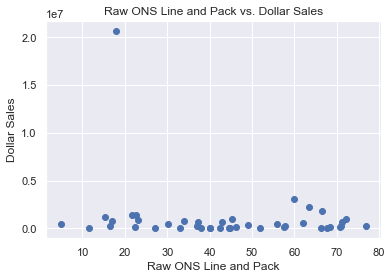

In [62]:
plt.title('Raw ONS Line and Pack vs. Dollar Sales')
plt.scatter(results_agg['Raw ONS Line and Pack'], results_agg['Dollar Sales'])
plt.xlabel('Raw ONS Line and Pack')
plt.ylabel('Dollar Sales')

In [63]:
# x, *columns = results_agg.columns

# for c in columns:
    
#     ro = results_agg[x].corr(results_agg[c])  # NOTE I believe this is returning a null-value, so need to dig into this more.
#     title = f"{x} vs. {c}\n{ro}"

#     plt.title(title)
#     plt.scatter(results_agg[x], results_agg[c])
#     plt.xlabel(x)
#     plt.ylabel(c)
#     plt.show()


In [64]:
# sns.pairplot(data=results_agg)

It's time to figure out the best way to get around the obvious scaling issues.
Clearly using "Dollar Sales" isn't viable.

What I wish we could do is actually perform some basic diff-in-diff analysis, but of course we don't have any temporal information that we can use to associate the input images with a point in time; let alone the number of interactions or however that's represented within the field of brick-and-mortar sales. 

Reviewing the reports though, I _think_ I have an idea related to how I've aggregated the reports.
Each of the sheets within the [[BEHAVIORALLY] ONS Validation_dcs_processed_v1.3.xlsx](https://docs.google.com/spreadsheets/d/12aDefcKhb9-LSILRo0t5ttLLxvxfe81ft-MYJhLbVYk/edit?usp=sharing) spreadsheet file corresponds to a report covering a given week.

What if instead we looked at average changes?
I simply don't think there's time rn.

Let's look at changes in 
